## DS 410 Final Project

Importing libraries, Creating Spark Session, and Reading in the Dataset

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import lower
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
import xgboost
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import sparknlp

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk



# Download NLTK data
nltk.download('punkt', quiet=True)


/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


True

In [ ]:
ss=SparkSession.builder.master("local").appName("Final_Project").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/25 15:29:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
ss.sparkContext.setCheckpointDir("~/scratch")

In [ ]:
schema = StructType([StructField("Sentiment", IntegerType(), nullable = False), \
                     StructField("Title", StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False)
                    ])

In [ ]:
reviews1 = ss.read.csv("Amazon_reviews_sample.csv", schema = schema, header = True, inferSchema = False)

In [ ]:
reviews = reviews1.na.drop()

In [ ]:
reviews.printSchema()

root
 |-- Sentiment: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Text: string (nullable = true)



In [ ]:
reviews.show(5)

+---------+--------------------+--------------------+
|Sentiment|               Title|                Text|
+---------+--------------------+--------------------+
|        1|Sorry I wasted my...|Neil Gaiman wrote...|
|        1|Loved the prose, ...|Rabbit was not a ...|
|        2|         FASCINATING|Am a Jack Higgins...|
|        1|Little Annie Fann...|This was very, ve...|
|        2|     pressing matter|I have owned Rowe...|
+---------+--------------------+--------------------+
only showing top 5 rows


## EDA

## Distribution of Review Sentiment

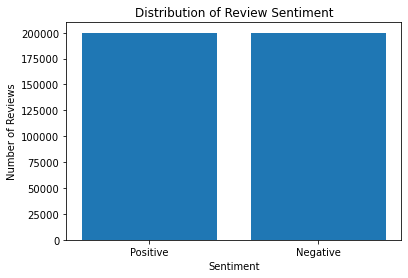

In [ ]:
reviews_label = reviews.withColumn("Labeled Sentiment", when(reviews["Sentiment"] == 2, "Positive").when(reviews["Sentiment"] == 1, "Negative"))
sentiment_counts = reviews_label.groupBy("Labeled Sentiment").count()
pandas_sentiment=sentiment_counts.toPandas()
plt.bar(pandas_sentiment["Labeled Sentiment"],pandas_sentiment["count"])
plt.title("Distribution of Review Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Removing special characters

In [ ]:
from pyspark.sql.functions import regexp_replace
reviews_special_title = reviews_label.withColumn("Title", regexp_replace("Title", "[^a-zA-Z0-9\\s]", ""))
reviews_only_text = reviews_special_title.withColumn("Text", regexp_replace("Text", "[^a-zA-Z0-9\\s]", ""))

Making all words lowercase and splitting by space

In [ ]:
reviews_split_title = reviews_label.withColumn("Title", split(lower(reviews_label["Title"]), " "))
reviews_split_title_text = reviews_split_title.withColumn("Text", split(lower(reviews_split_title["Text"]), " "))

Removing stop words, making rdd of title of reviews and text of reviews for positive and negative sentiment

In [ ]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCols=["Title", "Text"], outputCols=["Title (No Stop Words)", "Text (No Stop Words)"])
reviews_no_stop_words = remover.transform(reviews_split_title_text)
reviews_title_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_title_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)

Concatenate title and reviews rdd for positive and negative sentiment

In [ ]:
reviews_pos = reviews_title_flat_pos.union(reviews_text_flat_pos)
reviews_neg = reviews_title_flat_neg.union(reviews_text_flat_neg)

Map words to key-value pairs ex. (word, 1)

In [ ]:
reviews_pos_key_val = reviews_pos.map(lambda x: (x, 1))
reviews_neg_key_val = reviews_neg.map(lambda x: (x, 1))

Reduce key-value pairs by key (aggregate counts of words)

In [ ]:
reviews_pos_key_val_reduced = reviews_pos_key_val.reduceByKey(lambda x, y: x + y, 4)
reviews_neg_key_val_reduced = reviews_neg_key_val.reduceByKey(lambda x, y: x + y, 4)

Sort aggregated counts of words in descending order

In [ ]:
reviews_pos_key_val_sorted = reviews_pos_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)
reviews_neg_key_val_sorted = reviews_neg_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)

Get ten most frequent words for title of reviews and text of reviews

In [ ]:
reviews_pos_key_val_sorted_top_ten = reviews_pos_key_val_sorted.take(10)
reviews_neg_key_val_sorted_top_ten  = reviews_neg_key_val_sorted.take(10)

## Bar graph of ten most frequent words in positive reviews

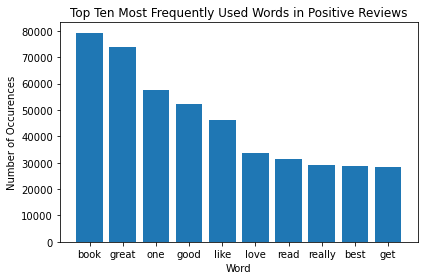

In [ ]:
plt.bar([item[0] for item in reviews_pos_key_val_sorted_top_ten], [item[1] for item in reviews_pos_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Positive Reviews")
plt.tight_layout()
plt.show()

## Bar graph of ten most frequent words in negative reviews

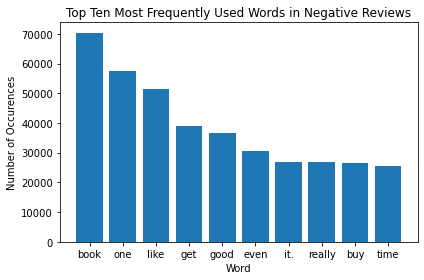

In [ ]:
plt.bar([item[0] for item in reviews_neg_key_val_sorted_top_ten], [item[1] for item in reviews_neg_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Negative Reviews")
plt.tight_layout()
plt.show()

# PreProcessing Data

### Add Stemming
Stemming reduces words to their root form (e.g., "running" -> "run", "playing" -> "play"

Remove punctuation from each word and apply Porter Stemmer. (Porter Stemmer is a process of removing suffixes of words in five steps, reducing them to their root form, as degined above!)
    
Example:
- Input:  ['sorry', 'wasted', 'time.', 'book!']
- Output: ['sorri', 'wast', 'time', 'book']

Import Libraries Needed for Stemming

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType
from nltk.stem.porter import PorterStemmer
import nltk
import re

# Download NLTK data (run once)
try:
    nltk.download('punkt', quiet=True)
    #print("✓ NLTK data downloaded")
except:
    print("NLTK data already available")


In [ ]:
def clean_and_stem_words(words):
    #Remove punctuation from each word and apply Porter Stemmer

    if words is None:
        return []

    stemmer = PorterStemmer()
    cleaned_stemmed = []

    for word in words:
        # Remove all non-alphabetic characters (punctuation, numbers, symbols)
        clean_word = re.sub(r'[^a-zA-Z]', '', word)

        # Only process if something remains after cleaning
        if clean_word:
            # Apply stemming
            stemmed = stemmer.stem(clean_word.lower())
            cleaned_stemmed.append(stemmed)

    return cleaned_stemmed

#Spark UDF
clean_stem_udf = udf(clean_and_stem_words, ArrayType(StringType()))

#print("✓ Stemming function created (with punctuation removal)!")


### Apply stemming function to Reviews given

In [ ]:
# Columns are named "Title (No Stop Words)" and "Text (No Stop Words)"
# with spaces and parentheses, use backticks to reference columns with spaces
# we apply the clean stemming function to these cells

# Apply to both columns
reviews_stemmed = reviews_no_stop_words.withColumn(
    "Title_Stemmed",
    clean_stem_udf(col("`Title (No Stop Words)`"))
).withColumn(
    "Text_Stemmed",
    clean_stem_udf(col("`Text (No Stop Words)`"))
)

#print(f"Stemming Total records: {reviews_stemmed.count():,}")

# Show example of the transformation
#print("\n" + "="*70)
#print("EXAMPLE: Before vs After Cleaning + Stemming")
#print("="*70)


# sample = reviews_stemmed.select(
#     "`Title (No Stop Words)`",
#     "Title_Stemmed",
#     "`Text (No Stop Words)`",
#     "Text_Stemmed"
# ).first()

# print("\n📝 TITLE:")
# print(f"  Before: {sample['Title (No Stop Words)'][:5]}")
# print(f"  After:  {sample['Title_Stemmed'][:5]}")

# print("\n📝 TEXT:")
# print(f"  Before: {sample['Text (No Stop Words)'][:5]}")
# print(f"  After:  {sample['Text_Stemmed'][:5]}")

# print("\n✓ Punctuation removed and words stemmed!")
# print("="*70)


### Preparing Data for Hugging Face

Formatting to be used by transformers

In [ ]:
from pyspark.sql.functions import concat_ws, array_join, when

# Combine stemmed title + text into one column for transformers that can be used for model output
# Create binary labels (0=Negative, 1=Positive) used by Hugging Face.

reviews_for_transformers = reviews_stemmed.withColumn(
    "text",  # Column name expected by Hugging Face
    concat_ws(" ",
              array_join(col("Title_Stemmed"), " "),
              array_join(col("Text_Stemmed"), " "))
).withColumn(
    "label",  # Binary label: 0=Negative, 1=Positive
    when(col("Sentiment") == 2, 1).otherwise(0)
).select("text", "label", "Sentiment", "Labeled Sentiment")

#print("Data prepared for Hugging Face transformers!")
#print("\n" + "="*70)
#print("Sample of Transformer-Ready Data:")
#print("="*70)
#reviews_for_transformers.show(3, truncate=70, vertical=False)

#print("\nData format:")
#print("  • text:   Combined, cleaned, stemmed review text")
#print("  • label:  Binary (0=Negative, 1=Positive)")
#print("  • Ready for BERT, RoBERTa, DistilBERT, etc.")


## Creating Test Train Split
Split data: 60% training, 20% validation, 20% testing
- Validation is used for hyperparameter tuning
- Test is used for final model evaluation
- Use seed for reproducibility

In [ ]:
# Split data: 60% training, 20% testing, 20% validation
# Use seed for reproducibility
train_data, valid_data, test_data = reviews_for_transformers.randomSplit([0.6, 0.2, 0.2], seed=42)

# Cache all three sets for faster access during modeling
train_data.cache()
valid_data.cache()
test_data.cache()


# Count records (forces computation and caching)
train_count = train_data.count()
valid_count = valid_data.count()
test_count = test_data.count()
total_count = train_count + valid_count + test_count


# print("Data split complete!")
# print("\n" + "="*70)
# print("Dataset Statistics:")
# print("="*70)
# print(f"  Training set: {train_count:,} records ({100*train_count/total_count:.1f}%)")
# print(f"  Test set:     {test_count:,} records ({100*test_count/total_count:.1f}%)")
# print(f"  Total:        {total_count:,} records")

# # Check label distribution in both sets
# print("\n" + "="*70)
# print("Label Distribution:")
# print("="*70)

# print("\n📊 Training Set:")
# train_label_dist = train_data.groupBy("label", "Labeled Sentiment").count().orderBy("label")
# train_label_dist.show()

# print("📊 Test Set:")
# test_label_dist = test_data.groupBy("label", "Labeled Sentiment").count().orderBy("label")
# test_label_dist.show()

# # Check if balanced
# train_labels = train_data.groupBy("label").count().collect()
# balance_ratio = min(train_labels[0]['count'], train_labels[1]['count']) / max(train_labels[0]['count'], train_labels[1]['count'])
# print(f"Class balance: {balance_ratio:.2%} ({'Balanced' if balance_ratio > 0.9 else 'Slightly imbalanced'})")



print(f"Split Complete:")
print(f"  Training:   {train_count:,} ({train_count/(train_count+valid_count+test_count)*100:.1f}%)")
print(f"  Validation: {valid_count:,} ({valid_count/(train_count+valid_count+test_count)*100:.1f}%)")
print(f"  Test:       {test_count:,} ({test_count/(train_count+valid_count+test_count)*100:.1f}%)")


Split Complete:
  Training:   240,349 (60.1%)
  Validation: 79,658 (19.9%)
  Test:       79,967 (20.0%)


## Saving Preprocessed Data

This step saves the cleaned and split datasets (train, validation, test) to disk in Parquet format so they can be reloaded later without rerunning preprocessing. Each dataset is written to its own folder for efficient access during model training.

Key points:

- Stores final data in /preprocessed_data_sample directory
- Uses mode("overwrite") to replace old files
- Parquet format = fast, compressed, and Spark-friendly
- Makes results reproducible and ready for transformer models

In [ ]:
# Set output path
OUTPUT_PATH = "preprocessed_data_sample"

# print("="*70)
# print("Saving Preprocessed Data...")
# print("="*70)

# # Save training data
# print(f"\nSaving training data...")
# train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/train_transformer_ready/")

# # Save validation data (NEW!)
# print(f"\nSaving validation data...")
# valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/valid_transformer_ready/")

# # Save test data
# print(f"\nSaving test data...")
# test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")
# print(f"   Saved to: {OUTPUT_PATH}/test_transformer_ready/")

# # Save full stemmed dataset (includes all columns for reference)
# print(f"\nSaving full stemmed dataset...")
# reviews_stemmed.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/reviews_stemmed")
# print(f"   Saved to: {OUTPUT_PATH}/reviews_stemmed/")

# print("\n" + "="*70)
# print("All data saved successfully!")
# print("="*70)
# print(f"\nModeling team can load with:")
# print(f'  train_df = spark.read.parquet("{OUTPUT_PATH}/train_transformer_ready")')
# print(f'  valid_df = spark.read.parquet("{OUTPUT_PATH}/valid_transformer_ready")')
# print(f'  test_df = spark.read.parquet("{OUTPUT_PATH}/test_transformer_ready")')



print("Saving data: ")

train_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/train_transformer_ready")
print(f" Training saved")

valid_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/valid_transformer_ready")
print(f" Validation saved")

test_data.write.mode("overwrite").parquet(f"{OUTPUT_PATH}/test_transformer_ready")
print(f" Test saved")

# Free up memory
train_data.unpersist()
valid_data.unpersist()
test_data.unpersist()

print("All data saved and memory freed!")
print(f"\nModeling team can load with:")
print(f'  spark.read.parquet("{OUTPUT_PATH}/train_transformer_ready")')
print(f'  spark.read.parquet("{OUTPUT_PATH}/valid_transformer_ready")')
print(f'  spark.read.parquet("{OUTPUT_PATH}/test_transformer_ready")')



Saving data: 


 Training saved
 Validation saved
 Test saved
All data saved and memory freed!

Modeling team can load with:
  spark.read.parquet("preprocessed_data_sample/train_transformer_ready")
  spark.read.parquet("preprocessed_data_sample/valid_transformer_ready")
  spark.read.parquet("preprocessed_data_sample/test_transformer_ready")


In [ ]:
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes

In [ ]:
#general data prep
train_df = ss.read.parquet("preprocessed_data_sample/train_transformer_ready")
valid_df = ss.read.parquet("preprocessed_data_sample/valid_transformer_ready")
test_df  = ss.read.parquet("preprocessed_data_sample/test_transformer_ready")
for name in ("train_df","valid_df","test_df"):
    locals()[name] = locals()[name].withColumn("label", col("label").cast("double"))
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tf  = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=50_000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
featurizer = Pipeline(stages=[tokenizer, tf, idf]).fit(train_df)
train_f = featurizer.transform(train_df).select("features", "label").repartition(1).cache()
valid_f = featurizer.transform(valid_df).select("features", "label").repartition(1).cache()
test_f  = featurizer.transform(test_df).select("features", "label").repartition(1).cache()

In [ ]:
#General model training function
def evaluate_model(model):
    pipeline = Pipeline(stages=[tokenizer, tf, idf, model])
    model = pipeline.fit(train_df)

    valid_pred = model.transform(valid_df)
    e_aucpr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
    e_auc   = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    e_f1    = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    e_acc   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    print("Validation — AUC-PR:", e_aucpr.evaluate(valid_pred))
    print("AUC-ROC:", e_auc.evaluate(valid_pred))
    print("F1:", e_f1.evaluate(valid_pred))
    print("Acc:", e_acc.evaluate(valid_pred))

    valid_scores = valid_pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])
    pdf = valid_scores.select("label", "raw_score").toPandas()
    fpr, tpr, _ = roc_curve(pdf["label"], pdf["raw_score"])
    plt.figure(figsize=(7, 6))
    plt.plot(tpr, fpr, linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--")  # diagonal reference line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.show()

# SVM

In [ ]:
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100, regParam=0.1)
evaluate_model(svm)

# Decision Tree

In [ ]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
evaluate_model(dt)

# Random Forest

In [ ]:
# Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,
    maxDepth=5,
    featureSubsetStrategy="auto",
)

# Pipeline
#pipeline = Pipeline(stages=[tokenizer, tf, rf])

evaluate_model(rf)

# Naive Bayes

In [ ]:
nb = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial",
    smoothing=1.0  # default Laplace smoothing
)

# Full pipeline
#pipeline = Pipeline(stages=[tokenizer, tf, nb])

# Train model
evaluate_model(nb)

# XG Boost

In [ ]:
pos = train_f.filter(col("label") == 1.0).count()
neg = train_f.filter(col("label") == 0.0).count()
scale_pos_weight = float(neg) / max(float(pos), 1.0)

xgb = SparkXGBClassifier(features_col="features",
                         label_col="label",
                         prediction_col="prediction",
                         probability_col="probability",
                         raw_prediction_col="rawPrediction",
                         num_workers=1,
                         tree_method="hist",
                         eval_metric="aucpr",
                         max_depth=6,
                         eta=0.1,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         reg_lambda=1.0,
                         reg_alpha=0.0,
                         scale_pos_weight=scale_pos_weight
)
#evaluate_model(xgb)

25/11/25 16:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1230.6 KiB
25/11/25 16:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1239.0 KiB
25/11/25 16:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1230.8 KiB
25/11/25 16:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1239.2 KiB
25/11/25 16:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1230.3 KiB
25/11/25 16:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1238.7 KiB
25/11/25 16:29:35 WARN DAGScheduler: Broadcasting large task binary with size 1230.2 KiB
25/11/25 16:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1238.6 KiB
25/11/25 16:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1230.0 KiB
25/11/25 16:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1238.4 KiB
25/11/25 16:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1230.6 KiB
25/11/25 16:30:53 WAR

Best hyperparameters:
regParam: 0.13826232179369854
maxIter: 60
tol: 3.387255565852147e-05
fitIntercept: False
standardization: False
AUC-ROC: 0.9361, AUC-PR: 0.3112, F1: 0.8650, Accuracy: 0.8648


25/11/25 16:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1223.3 KiB


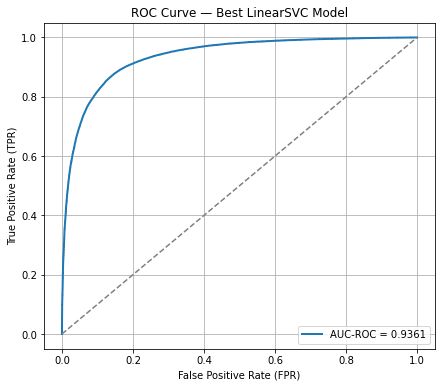

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.functions import vector_to_array
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, average_precision_score, f1_score, accuracy_score
import random

# ----------------------------
# 1. Define pipeline
# ----------------------------
svm = LinearSVC(featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[tokenizer, tf, idf, svm])

# ----------------------------
# 2. Generate random parameter grid
# ----------------------------
n_samples = 25  # number of random combinations
np.random.seed(42)
random.seed(42)

param_grid = []
for _ in range(n_samples):
    param_grid.append({
        svm.regParam: 10**np.random.uniform(-4, 0),
        svm.maxIter: np.random.randint(10, 200),
        svm.tol: 10**np.random.uniform(-6, -2),
        svm.fitIntercept: bool(np.random.choice([True, False])),
        svm.standardization: bool(np.random.choice([True, False])),
    })

# ----------------------------
# 3. Evaluator
# ----------------------------
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# ----------------------------
# 4. Loop over parameter samples
# ----------------------------
results = []

for params in param_grid:
    # Set params to classifier
    for p, v in params.items():
        svm.set(p, v)

    # Fit pipeline on training set
    model = pipeline.fit(train_df)

    # Predict on validation set
    pred = model.transform(valid_df)

    # Convert rawPrediction to scalar
    pred_scores = pred.withColumn("raw_score", vector_to_array("rawPrediction")[0])

    # Collect predictions to pandas
    pdf = pred_scores.select("label", "raw_score", "prediction").toPandas()

    # Compute metrics
    auc = evaluator_auc.evaluate(pred)
    auc_pr = average_precision_score(pdf["label"], pdf["raw_score"])
    f1 = f1_score(pdf["label"], pdf["prediction"])
    acc = accuracy_score(pdf["label"], pdf["prediction"])

    results.append({
        "params": params,
        "AUC_ROC": auc,
        "AUC_PR": auc_pr,
        "F1": f1,
        "Accuracy": acc
    })

# ----------------------------
# 5. Find best model by AUC-ROC
# ----------------------------
best_result = max(results, key=lambda x: x["AUC_ROC"])
print("Best hyperparameters:")
for p, v in best_result["params"].items():
    print(f"{p.name}: {v}")
print(f"AUC-ROC: {best_result['AUC_ROC']:.4f}, AUC-PR: {best_result['AUC_PR']:.4f}, "
      f"F1: {best_result['F1']:.4f}, Accuracy: {best_result['Accuracy']:.4f}")

# ----------------------------
# 6. Fit the best model again (optional if not already saved)
# ----------------------------
best_params = best_result["params"]

# Set best hyperparameters
for p, v in best_params.items():
    svm.set(p, v)

# Fit the pipeline on the training set and save it to a variable
best_pipeline_model = pipeline.fit(train_df)  # <-- This variable holds your best model

# You can now use best_pipeline_model later for predictions
# Example:
valid_pred = best_pipeline_model.transform(valid_df)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from pyspark.ml.functions import vector_to_array

# ----------------------------
# 7. Compute ROC for the best model
# ----------------------------

# Convert LinearSVC rawPrediction vector to scalar
valid_pred_scores = valid_pred.withColumn(
    "raw_score", vector_to_array("rawPrediction")[0]
)

# Collect predictions to pandas
pdf_valid = valid_pred_scores.select("label", "raw_score").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf_valid["label"], pdf_valid["raw_score"])

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {best_result['AUC_ROC']:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve — Best LinearSVC Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

25/11/25 16:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1230.2 KiB


AUC-PR: 0.3153
F1 Score: 0.8656
Accuracy: 0.8638


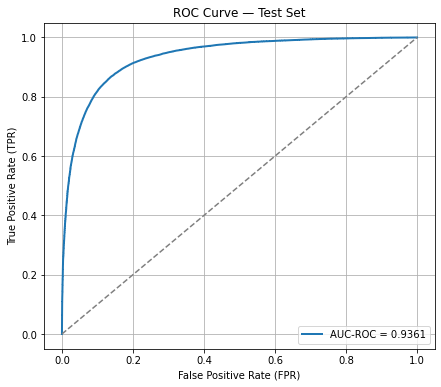

In [ ]:
from sklearn.metrics import roc_curve, average_precision_score, f1_score, accuracy_score
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt

# ----------------------------
# 1. Predict on test set
# ----------------------------
test_pred = best_pipeline_model.transform(test_df)

# Convert LinearSVC rawPrediction vector to scalar
test_pred_scores = test_pred.withColumn(
    "raw_score", vector_to_array("rawPrediction")[0]
)

# Collect predictions to pandas
pdf_test = test_pred_scores.select("label", "raw_score", "prediction").toPandas()

# ----------------------------
# 2. Compute ROC curve
# ----------------------------
fpr, tpr, _ = roc_curve(pdf_test["label"], pdf_test["raw_score"])

# ----------------------------
# 3. Compute AUC-PR, F1, and Accuracy
# ----------------------------
auc_pr = average_precision_score(pdf_test["label"], pdf_test["raw_score"])
f1 = f1_score(pdf_test["label"], pdf_test["prediction"])
acc = accuracy_score(pdf_test["label"], pdf_test["prediction"])

print(f"AUC-PR: {auc_pr:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

# ----------------------------
# 4. Plot ROC curve
# ----------------------------
plt.figure(figsize=(7, 6))
plt.plot(tpr, fpr, linewidth=2, label=f"AUC-ROC = {best_result['AUC_ROC']:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal reference line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve — Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
